In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchmetrics import Accuracy

from sklearn.metrics import classification_report

from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json
from math import ceil

In [115]:
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [116]:
"""
Fundamental convolution block:
    1 ==> Convolution layer
    2 ==> Batch normalization
    3 ==> Silu activation function
"""

class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=groups), # Specified to control how convolution is applied to input
                                      # If group = 1, kernel is applied to one channel only
                                      # if group = input channel, kernel is applied to one channel only

            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    
    def forward(self, x):
        return self.block(x)

In [117]:
"""
Squeeze and Excitation Block:
    Goal: To enhance feature representation by selectively amplifying important channels
    Mechanism: Take number of input channels as input and applying adaptive pooling to condense spatial dimensions
"""

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

In [118]:
"""
MobileNet-style Convolution Block (MBConv):
    Depthwise separable convolutions
    Squeeze-and-excitation block (SE)
"""

class MBConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBConv, self).__init__()

        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # Squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels=in_channels,
                                         out_channels=hidden_dim,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1)
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=hidden_dim),

            SqueezeExcitation(in_channels=hidden_dim,
                              reduced_dim=reduced_dim),

            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=out_channels,
                      kernel_size=1),

            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
            
        return self.conv(x)

In [119]:
"""
EfficientNet Class
"""

class EfficientNet(nn.Module):
    def __init__(self, model_name, output, mb_params, dropout_newVal):
        super(EfficientNet, self).__init__()
        
        phi, resolution, dropout = scale_values[model_name]

        if dropout_newVal != None:
            dropout = dropout_newVal

        if mb_params == None:
            mb_params = basic_mb_params

        self.mb_params = mb_params
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),

            nn.Linear(in_features=self.last_channels,
                      out_features=output),
        )

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)] # Stem convolution layer
        in_channels = channels

        for k, c_o, repeat, s, n in self.mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                features.append(
                        MBConv(in_channels=in_channels,
                               out_channels=out_channels,
                               ratio=k,
                               stride=stride,
                               kernel_size=n,
                               padding=(n//2))
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels=in_channels,
                      out_channels=self.last_channels,
                      kernel_size=1,
                      stride=1,
                      padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        
        return self.classifier(self.flatten(x))

In [120]:
## Dictionary for encoding labels

labelToNum_dict = {
    "angry" : 0,
    "disgust" : 1,
    "fear" : 2,
    "happy" : 3,
    "neutral" : 4,
    "sad" : 5,
    "surprise" : 6,
}

numTolabel_dict = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "neutral",
    5 : "sad",
    6: "surprise"
}

In [121]:
def loadDataset(res, batch_size, datasetType):
    base_dir = os.getcwd()
    folder_dir = os.path.join(base_dir, "processed_data", datasetType)
    
    transformation = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # Convert image to float ranging from 0 - 1
        v2.Resize((res, res)),
    ])

    dataset = ImageFolder(folder_dir, transform=transformation)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader


Train features batch shape: torch.Size([32, 3, 224, 224])
Train labels batch size: torch.Size([32])


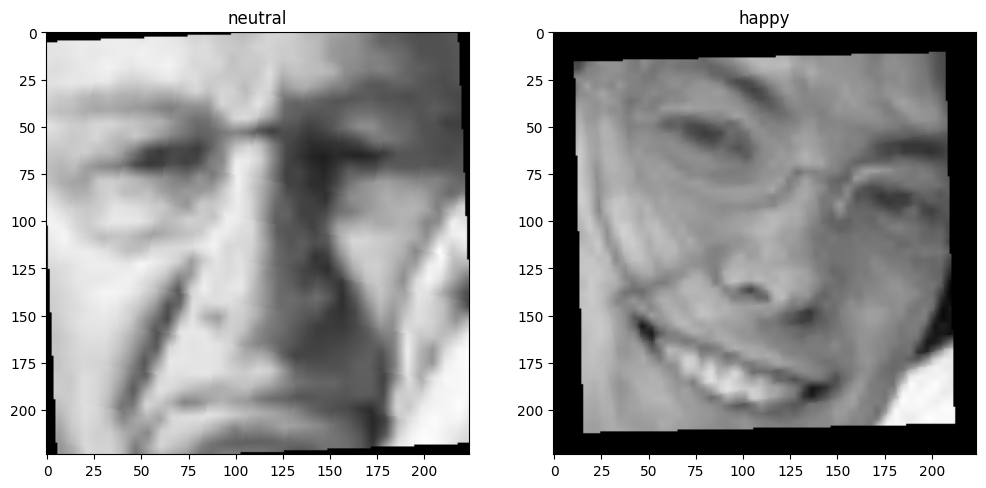

In [122]:
## New loading and testing train and validation datasets

train_loader = loadDataset(224, 32, "train")
val_loader = loadDataset(224, 32, "validation")

x_train, y_train = next(iter(train_loader))
x_val, y_val = next(iter(val_loader))

print(f"Train features batch shape: {x_train.size()}")
print(f"Train labels batch size: {y_train.size()}")

imgTrain = x_train[0].squeeze()
labelTrain = y_train[0]

imgVal = x_val[0].squeeze()
labelVal = y_val[0]

fig = plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(imgTrain.permute(1,2,0))
plt.title(numTolabel_dict[labelTrain.item()])

plt.subplot(1,2,2)
plt.imshow(imgVal.permute(1,2,0))
plt.title(numTolabel_dict[labelVal.item()])
plt.show()


In [ ]:
def setHyperparameters(model_type, num_class, batchSize, learningRate, device, mb_params, newDropoutRate, optimChoice):
    
    phi, resolution, dropout = scale_values[model_type]

    train_loader = loadDataset(resolution, batchSize, "train")
    test_loader = loadDataset(resolution, batchSize, "test")
    val_loader = loadDataset(resolution, batchSize, "validation")

    model = EfficientNet(model_name=model_type,
                         output=num_class,
                         mb_params=mb_params,
                         dropout_newVal=newDropoutRate)
    
    model.to(device)

    match (optimChoice):
        case "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        
        case "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr=learningRate)
        
        case "Adadelta":
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate)
        
        case "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        
        case _:
            print("ERROR. Optimizer choice inputted is not included in selection.\n PLEASE RESET MODEL OPTIMIZER's CHOICE.\n")

    return model, train_loader, test_loader, val_loader, optimizer

In [124]:
## Testing for whether CUDA is available for training

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Ti


In [ ]:
## Function for training model

def train_model(model, train_loader, device, lossFn, accFn, optimizer):
    
    torch.manual_seed(42) # 42 is the answer to everything!
    
    train_loss, train_acc = 0, 0

    for batch, (X, y) in tqdm(enumerate(train_loader), desc="Training Model on Num Batches", leave=False):
        model.train()

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # Still in logits from (probabilities)

        # 2. Calculate loss (per batch)
        loss = lossFn(y_pred, y)
        train_loss += loss
        train_acc += accFn(y_pred.argmax(dim=1), y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Divide total train loss and accuracy by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_acc *= 100

    return model, optimizer, train_loss, train_acc

In [ ]:
## Function for testing model

def test_model(model, test_loader, device, lossFn, accFn):
    
    torch.manual_seed(42)

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(test_loader, desc="Testing Model", leave=False):
            
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumulatively)
            test_loss += lossFn(test_pred, y)

            # 3. Calculate accuracy (preds need to be same as y)
            test_acc += accFn(test_pred.argmax(dim=1), y)
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_loader)

        # Times 100 to make it into a percentage
        test_acc *= 100
    
    return model, test_loss, test_acc

In [ ]:
## Function for entire training and testing loop with data saving

def model_train_test(model, epochs, train_loader, test_loader, device, lossFn, accFn, optimizer):
    history = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs), desc="Epochs Trained on Model"):

        print(f"Epochs: {epoch}\n----------------")

        ### Training
        model, optimizer, train_loss, train_acc = train_model(model, train_loader, device, lossFn, accFn, optimizer)

        ### Testing
        model, test_loss, test_acc = test_model(model, test_loader, device, lossFn, accFn)
        
        print(f"\nTrain loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
    
    return model, history
    

In [ ]:
## Function to save model and model weights

def save_model_and_modelWeights(model, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)

    modelStateDictName = model_name + "_weights.pth"
    modelEntireName = model_name + ".pth"

    modelStateDict_path = os.path.join(model_path, modelStateDictName)
    modelEntire_path = os.path.join(model_path, modelEntireName)

    # Save model's weight only
    if os.path.isfile(modelStateDict_path):
        print(f"\n{model_name} state dictionary file existed previously. New {model_name}'s state is not saved.")
    else:
        torch.save(model.state_dict(), modelStateDict_path)
        print(f"\n{model_name}'s state file has been successfully saved.")

    # Save entire model including layers and weights
    if os.path.isfile(modelEntire_path):
        print(f"\n{model_name} file existed previously. New {model_name} is not saved.")
    else:
        torch.save(model, modelEntire_path)
        print(f"\n{model_name} has been successfully saved.")

In [ ]:
def save_modelSettings(model_settings, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_settings.json")

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s settings file existed previously. New {model_name}'s settings file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(model_settings, file)
        
        print(f"\n{model_name}'s setting has been saved.\n")

In [ ]:
## Function to show and save model history

def show_and_save_trainTest_history(history, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_history.json")

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s history file existed previously. New {model_name}'s history file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(history, file)
        
        print(f"\n{model_name}'s training history has been saved.\n")

    # Checking model's training history

    for val_type in history:
        print(val_type)
        dataList = history[val_type]
        for i in range(0, len(history[val_type])):
            print(f"{i+1}. {dataList[i]:.4f}")
        print("")

In [ ]:
## Class for model hyperparameters and training settings

class ModelSet:
    def __init__(self, model_name, model_type, epochs, batchSize, learningRate, mb_params, newDropoutRate, optimChoice):
        self.model_name = model_name
        self.model_type = model_type
        self.num_class = 7
        self.epochs = epochs
        self.batchSize = batchSize
        self.learningRate = learningRate
        self.mb_params = mb_params
        self.newDropoutRate = newDropoutRate
        self.history = None
        self.optimChoice = optimChoice
    
    def model_setup(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model, self.train_loader, self.test_loader, self.val_loader, self.optimizer = setHyperparameters(model_type=self.model_type,
                                                                                                              num_class=self.num_class,
                                                                                                              batchSize=self.batchSize,
                                                                                                              learningRate=self.learingRate,
                                                                                                              device=self.device,
                                                                                                              mb_params=self.mb_params,
                                                                                                              newDropoutRate=self.newDropoutRate,
                                                                                                              optimChoice=self.optimChoice)

        self.lossFn = nn.CrossEntropyLoss()

        self.accFn = Accuracy('multiclass', num_classes=self.num_class).to(self.device)
    
    ## Function to save model settings as json file

    def generate_modelSettings_dict(self):

        phi, res, ori_dp_rate = scale_values[self.model_type]

        if self.newDropoutRate == None:
            self.newDropoutRate = ori_dp_rate

        modelSettings = {"model_name": self.model_name,
                         "model_type": self.model_type,
                         "num_class": 7,
                         "epochs": self.epochs,
                         "batch_size": self.batchSize,
                         "learning_rate": self.learningRate,
                         "MBConv parameters": self.mb_params,
                         "dropout_rate": self.newDropoutRate,
                         "optimizer": self.optimChoice,
                         "loss_function": "Cross Entropy Loss"}
        
        return modelSettings

In [ ]:
## Do not change this, only for reference!!
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Change any settings you want on this one
mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Do not change anything with it, only for reference!!
scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [ ]:
## Creating a model

if (mb_params == basic_mb_params):
    mb_params = basic_mb_params

model_2 = ModelSet(model_name="model_2", # Change names if you want to save different versions of models
                   model_type="b0", # from b0 --> b7
                   epochs=10, 
                   batchSize=32, # Typically in the power of 2
                   learningRate=0.001, # Different choices for different optimizers
                   mb_params=mb_params, # Can refer to previous block / If None, use basic settings
                   newDropoutRate=None, # Cann refer to previous block / If None, use basic settings
                   optimChoice="Adadelta") # Available choice: Adam, AdamW, Adadelta, SGD

model_2.model_setup() # Setting up everything

modelSettings = model_2.generate_modelSettings_dict()

In [ ]:
## Generate model summary

summary(model_2.model, (3, 224, 224))

In [ ]:
## Start training and testing loop

model_2.model, model_2.history = model_train_test(model=model_2.model,
                                          epochs=model_2.epochs,
                                          train_loader=model_2.train_loader,
                                          test_loader=model_2.test_loader,
                                          device=model_2.device,
                                          lossFn=model_2.lossFn,
                                          accFn=model_2.accFn,
                                          optimizer=model_2.optimizer)

In [ ]:
## Saving model settings, model files and model metrics

save_modelSettings(modelSettings, model_2.model_name)

save_model_and_modelWeights(model_2.model, model_2.model_name)

show_and_save_trainTest_history(model_2.history, model_2.model_name)